# Will Gasser | Homework 2 | Comp 6630

## README
required imports:
- numpy
- matplotlib
- time

## I had to mount my google drive, my relative file paths will not work for any other user, it is commented out but note the file imports are WRONG for any grader

The commentary and questions begin to be answered after I started performing analyses on the model results. Scroll down to see Question 1, just below my activation function tests.



In [ ]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import time

#from google.colab import drive #NOTE THIS IS MOUNTED!!!!
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Activation Functions
These functions transform the weighted sum of inputs into activations for each neuron. This is just the code implementation for the functions. Once I build our basic perceptron using these functions, I will then comment on the most optimal choice.

In [43]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def linear(Z):
    return Z

def linear_derivative(Z):
    return np.ones_like(Z)

def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z)**2

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return np.where(Z > 0, 1, 0)

## Network Initialization
These functions initialize our weights and biases and also define our forward pass and loss implementations. Here I wrote the intialize_model function to have a variable amount of neurons in each layer based on our argument inputs. Later I will dicuss how using this approach allowed me to tune my neuron count for optimal training.

In [44]:
def initialize_model(input_size, hidden_size, output_size):
    """Initialize weights and biases for a neural network with one hidden layer"""
    weights1 = np.random.randn(input_size, hidden_size) * np.sqrt(1 / input_size)
    bias1 = np.zeros((1, hidden_size))

    weights2 = np.random.randn(hidden_size, output_size) * np.sqrt(1 / hidden_size)
    bias2 = np.zeros((1, output_size))

    return [weights1, weights2], [bias1, bias2]

def forward_pass(X, weights, biases, hidden_activation=sigmoid, output_activation=linear, store_intermediates=False):
    Z1 = np.dot(X, weights[0]) + biases[0]
    A1 = hidden_activation(Z1)
    Z2 = np.dot(A1, weights[1]) + biases[1]
    A2 = output_activation(Z2)

    if store_intermediates:
        return A2, [(Z1, A1), (Z2, A2)]
    return A2

def compute_mse_loss(y_pred, y_true):
    m = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / (2 * m)


## Back Propogation
This was the most intensive portion of this exercise. Writing back propogation required me to understand the complexities of the chain rule in relation to adjusting our weights and biases with or previous activations and z's. Once I was able to simplify the notation however, back propogation has a very neat vectorized form. Additionally, this helped bolster my skills in numpy with manipulating matrices.

In [45]:
def backward_pass(X, y, weights, biases, intermediates, hidden_activation_derivative=sigmoid_derivative, output_activation_derivative=linear_derivative):
    m = X.shape[0]
    Z1, A1 = intermediates[0]
    Z2, A2 = intermediates[1]

    dZ2 = (A2 - y) * output_activation_derivative(Z2)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Gradients for hidden layer
    dA1 = np.dot(dZ2, weights[1].T)
    dZ1 = dA1 * hidden_activation_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return [dW1, dW2], [db1, db2]

def update_parameters(weights, biases, weight_grads, bias_grads, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * weight_grads[i]
        biases[i] -= learning_rate * bias_grads[i]
    return weights, biases


## Training Function
This function includes l2 normalization and early stopping. It also allows us to input our custom activation functions to train our model with.

In [46]:
def train_model(X_train, Y_train, X_val=None, Y_val=None, hidden_size=10,
                epochs=1000, learning_rate=0.01,
                hidden_activation=sigmoid, hidden_activation_derivative=sigmoid_derivative,
                output_activation=linear, output_activation_derivative=linear_derivative,
                early_stopping=False, patience=10, verbose=True, l2_reg=0.0):

    n_samples, input_size = X_train.shape
    _, output_size = Y_train.shape if len(Y_train.shape) > 1 else (n_samples, 1)

    Y_train = Y_train.reshape(-1, output_size)
    if Y_val is not None:
        Y_val = Y_val.reshape(-1, output_size)

    # Initialize model
    weights, biases = initialize_model(input_size, hidden_size, output_size)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    best_biases = None

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        y_pred, intermediates = forward_pass(
            X_train, weights, biases,
            hidden_activation, output_activation,
            store_intermediates=True
        )
        train_loss = compute_mse_loss(y_pred, Y_train)

        if l2_reg > 0:
            l2_loss = 0
            for w in weights:
                l2_loss += np.sum(np.square(w))
            train_loss += (l2_reg / (2 * n_samples)) * l2_loss

        train_losses.append(train_loss)

        weight_grads, bias_grads = backward_pass(
            X_train, Y_train, weights, biases, intermediates,
            hidden_activation_derivative, output_activation_derivative
        )

        # L2 regularization for gradients
        if l2_reg > 0:
            for i in range(len(weights)):
                weight_grads[i] += (l2_reg / n_samples) * weights[i]

        weights, biases = update_parameters(weights, biases, weight_grads, bias_grads, learning_rate)

        if X_val is not None and Y_val is not None:
            val_pred = forward_pass(X_val, weights, biases, hidden_activation, output_activation)
            val_loss = compute_mse_loss(val_pred, Y_val)

            # Add L2 regularization to validation loss if enabled
            if l2_reg > 0:
                l2_loss = 0
                for w in weights:
                    l2_loss += np.sum(np.square(w))
                val_loss += (l2_reg / (2 * X_val.shape[0])) * l2_loss

            val_losses.append(val_loss)

            # Early stopping
            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = [w.copy() for w in weights]
                    best_biases = [b.copy() for b in biases]
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if verbose:
                            print(f"Early stopping at epoch {epoch+1}")
                        weights = best_weights
                        biases = best_biases
                        break

        if verbose and (epoch+1) % 100 == 0:
            if X_val is not None and Y_val is not None:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_losses[-1]:.6f}, Time: {time.time() - epoch_start:.2f}s")
            else:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Time: {time.time() - epoch_start:.2f}s")

    if verbose:
        print(f"Total training time: {time.time() - start_time:.2f}s")

    if early_stopping and best_weights is not None:
        weights = best_weights
        biases = best_biases

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses if val_losses else None
    }

    return weights, biases, history

def test_model(X, Y, weights, biases, hidden_activation=sigmoid, output_activation=linear):
    Y = Y.reshape(-1, 1) if len(Y.shape) == 1 else Y
    predictions = forward_pass(X, weights, biases, hidden_activation, output_activation)
    mse = compute_mse_loss(predictions, Y)
    return predictions, mse

In [47]:
def reshape_data_for_nn(X_train, Y_train, X_test, Y_test):
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    Y_train = Y_train.reshape(-1, 1) if len(Y_train.shape) == 1 else Y_train
    Y_test = Y_test.reshape(-1, 1) if len(Y_test.shape) == 1 else Y_test

    return X_train, Y_train, X_test, Y_test

def normalize_data(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std[std == 0] = 1

    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std

    return X_train_norm, X_test_norm, mean, std

def split_data(X, Y, validation_ratio=0.2, shuffle=True):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)

    if shuffle:
        np.random.shuffle(indices)

    val_size = int(n_samples * validation_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train, X_val = X[train_indices], X[val_indices]
    Y_train, Y_val = Y[train_indices], Y[val_indices]

    return X_train, Y_train, X_val, Y_val

In [48]:
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    if history['val_loss'] is not None:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(X, Y_true, Y_pred, title="Predictions vs True Values"):
    plt.figure(figsize=(12, 10))

    ax = plt.subplot(2, 1, 1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], Y_true, color='blue', label='True Values')
    ax.scatter(X[:, 0], X[:, 1], Y_pred, color='red', alpha=0.5, label='Predictions')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Y')
    ax.set_title('3D Visualization of Predictions')
    ax.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_learning_rate_curve(learning_rates, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, losses, marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('MSE Loss')
    plt.title('Learning Rate vs MSE Loss')
    plt.grid(True)
    plt.xscale('log')
    plt.show()

def plot_neuron_count_curve(neuron_counts, losses):
    plt.figure(figsize=(10, 6))
    plt.plot(neuron_counts, losses, marker='o')
    plt.xlabel('Number of Neurons in Hidden Layer')
    plt.ylabel('MSE Loss')
    plt.title('Hidden Layer Neurons vs MSE Loss')
    plt.grid(True)
    plt.show()

def plot_compare_activations(activation_names, losses):
    plt.figure(figsize=(10, 6))
    plt.bar(activation_names, losses)
    plt.xlabel('Activation Function')
    plt.ylabel('MSE Loss')
    plt.title('Activation Function Comparison')
    plt.grid(True, axis='y')
    plt.show()

In [49]:
X_train = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/X_train.csv")
Y_train = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/Y_train.csv")
X_test = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/X_test.csv")
Y_test = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/Y_test.csv")

print("Data loaded successfully!")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape if isinstance(Y_train, np.ndarray) else (len(Y_train),)}")

X_train, Y_train, X_test, Y_test = reshape_data_for_nn(X_train, Y_train, X_test, Y_test)

# Normalize features
X_train_norm, X_test_norm, mean, std = normalize_data(X_train, X_test)

Data loaded successfully!
X_train shape: (100, 2)
Y_train shape: (100,)


In [50]:
hidden_size = 100 # This is overfitting for sure
learning_rate = .001
epochs = 2000

In [51]:
print("Training baseline model with:")
print(f"Hidden layer neurons: {hidden_size}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}")

weights, biases, history = train_model(
    X_train_norm, Y_train,
    hidden_size=hidden_size,
    epochs=epochs,
    learning_rate=learning_rate,
    verbose=True

)

Training baseline model with:
Hidden layer neurons: 100
Learning rate: 0.001
Epochs: 2000
Epoch 100/2000, Train Loss: 1402.472229, Time: 0.00s
Epoch 200/2000, Train Loss: 347.742998, Time: 0.00s
Epoch 300/2000, Train Loss: 137.875315, Time: 0.00s
Epoch 400/2000, Train Loss: 104.920958, Time: 0.00s
Epoch 500/2000, Train Loss: 91.723842, Time: 0.00s
Epoch 600/2000, Train Loss: 81.584314, Time: 0.00s
Epoch 700/2000, Train Loss: 73.066229, Time: 0.00s
Epoch 800/2000, Train Loss: 65.901070, Time: 0.00s
Epoch 900/2000, Train Loss: 59.876029, Time: 0.00s
Epoch 1000/2000, Train Loss: 54.792506, Time: 0.00s
Epoch 1100/2000, Train Loss: 50.477785, Time: 0.00s
Epoch 1200/2000, Train Loss: 46.788454, Time: 0.00s
Epoch 1300/2000, Train Loss: 43.608453, Time: 0.00s
Epoch 1400/2000, Train Loss: 40.845107, Time: 0.00s
Epoch 1500/2000, Train Loss: 38.424827, Time: 0.00s
Epoch 1600/2000, Train Loss: 36.289190, Time: 0.00s
Epoch 1700/2000, Train Loss: 34.391665, Time: 0.00s
Epoch 1800/2000, Train Loss: 3

# Question 1 & 2

1) The linear activation was chosen by the nature of the target variable, which is a continuous, unbounded value, making a linear output more suitable than bounded alternatives like tanh or sigmoid. The linear activation ensures unrestricted output range and facilitates direct error minimization via gradient descent, enhancing predictive accuracy and convergence stability for this regression task.

2) The output layer consists of a single neuron, as the predicted variable, Y, is a scalar value representing a singular outcome. The objective of the model is to accurately estimate this individual value. Employing multiple neurons in the output layer would imply a multidimensional output, which exceeds the scope and complexity required for this investigation. Thus, a single output neuron was determined to be the most appropriate configuration for aligning the model’s architecture with the predictive task at hand.


Loss curve:


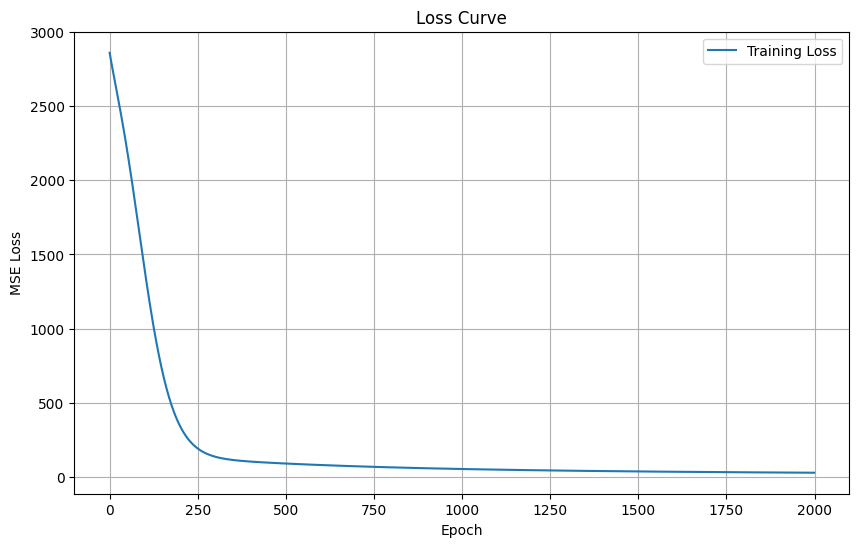

In [52]:
print("Loss curve:")
plot_loss_curve(history)

# Questions 3 & 4

3) The average mean squared error (MSE) loss exhibits significant variation as a function of the number of epochs selected for training the model. The results indicate that with a limited number of epochs, the average MSE remains high, often reaching values in the order of thousands, reflecting poor model convergence. Conversely, when a larger epoch size is employed, the average MSE loss decreases substantially, approaching a minimal value proximate to zero. This observation suggests that extended training iterations enhance the model’s ability to minimize prediction error and achieve optimal performance.

4) The graph presented above depicts the loss function, where each epoch represents a complete iteration over the dataset. The function is defined such that f(iteration)=loss, with the MSE loss plotted against the number of epochs. This visualization quantifies the progressive reduction in error as the model iterates through the training data.

  Testing learning rate: 0.001
  Learning rate 0.001: MSE = 27.063579
  Testing learning rate: 0.002
  Learning rate 0.002: MSE = 16.093551
  Testing learning rate: 0.003
  Learning rate 0.003: MSE = 13.400635
  Testing learning rate: 0.004
  Learning rate 0.004: MSE = 9.777965
  Testing learning rate: 0.005
  Learning rate 0.005: MSE = 5.304429
  Testing learning rate: 0.006
  Learning rate 0.006: MSE = 2.999052
  Testing learning rate: 0.007
  Learning rate 0.007: MSE = 1.715383
  Testing learning rate: 0.008
  Learning rate 0.008: MSE = 1.415253
  Testing learning rate: 0.009000000000000001
  Learning rate 0.009000000000000001: MSE = 0.572837
  Testing learning rate: 0.010000000000000002
  Learning rate 0.010000000000000002: MSE = 0.587347
  Testing learning rate: 0.011
  Learning rate 0.011: MSE = 0.322847
  Testing learning rate: 0.012
  Learning rate 0.012: MSE = 0.264724
  Testing learning rate: 0.013000000000000001
  Learning rate 0.013000000000000001: MSE = 0.418027
  Testing 

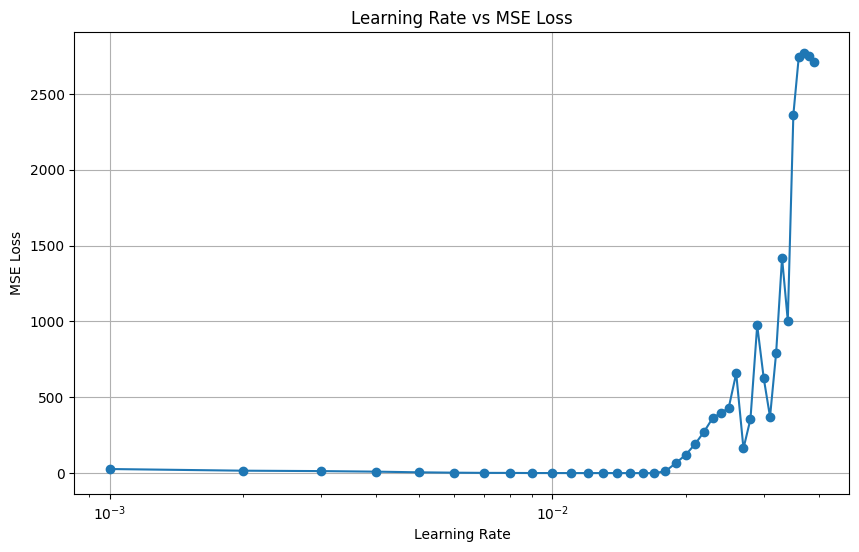

In [53]:
learning_rates = list(np.arange(0.001, .04, .001))
lr_mse_results = []

for lr in learning_rates:
    print(f"  Testing learning rate: {lr}")
    w, b, h = train_model(
        X_train_norm, Y_train,
        hidden_size=hidden_size,
        epochs=100,
        learning_rate=lr,
        verbose=False,
        hidden_activation=relu,
        hidden_activation_derivative=relu_derivative,
    )

    # Test model
    _, mse = test_model(X_test_norm, Y_test, w, b, hidden_activation=relu)
    lr_mse_results.append(mse)
    print(f"  Learning rate {lr}: MSE = {mse:.6f}")

plot_learning_rate_curve(learning_rates, lr_mse_results)

# Question 5

The ReLu activation function demonstrates heightened sensitivity to the magnitude of the learning rate during model training. Testing revealed that learning rates approaching 1 frequently resulted in numerical instability, manifesting as overflow errors or NaN values, which disrupted convergence. To mitigate these issues, a bounded range of [0.001, 0.04] was selected for the learning rate. Further analysis of the MSE loss across this range indicates that the optimal learning rate for ReLU approximates 0.01, as this value consistently minimized error without compromising numerical stability.

  Testing with 1 neurons in hidden layer
  Testing with 2 neurons in hidden layer
  Testing with 3 neurons in hidden layer
  Testing with 4 neurons in hidden layer
  Testing with 5 neurons in hidden layer
  Testing with 6 neurons in hidden layer
  Testing with 7 neurons in hidden layer
  Testing with 8 neurons in hidden layer
  Testing with 9 neurons in hidden layer
  Testing with 10 neurons in hidden layer


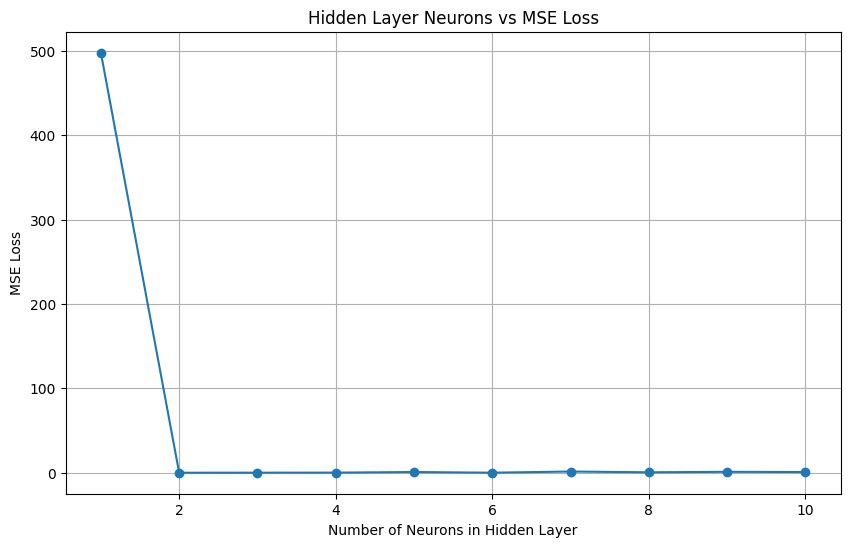

Average MSE: 50.24802959113924


In [58]:
neuron_counts = list(range(1, 11))
neuron_mse_results = []

for neuron_count in neuron_counts:
    print(f"  Testing with {neuron_count} neurons in hidden layer")
    w, b, h = train_model(
        X_train_norm, Y_train,
        hidden_size=neuron_count,
        epochs=epochs,
        learning_rate=learning_rate,
        hidden_activation=relu,
        hidden_activation_derivative=relu_derivative,
        verbose=False
    )

    predictions, mse = test_model(X_test_norm, Y_test, w, b, hidden_activation=relu)
    neuron_mse_results.append(mse)


plot_neuron_count_curve(neuron_counts, neuron_mse_results)
print(f'Average MSE: {np.mean(neuron_mse_results)}')

# Question 6

a. The gradient of the loss function with respect to the parameters did not require re-derivation or modification. This is because the update rule is independent of the network architecture’s scale or number of neurons. The gradients are computed via backpropagation, which adapts automatically to the number of neurons by adjusting the dimensionality of the weight matrices and bias vectors.

b. The model’s performance was evaluated by measuring the final mean squared error (MSE) loss and comparing true labels against predicted labels for each configuration (1 to 10 neurons). Experimental results indicate that increasing the number of neurons beyond 3 yields negligible improvements in model performance. With 3 or more neurons, the MSE loss converges to a minimal value, and the predicted labels align closely with the true labels, suggesting the model fully captures the underlying data distribution.

Testing effect of activation functions:
  sigmoid: MSE = 72.922708


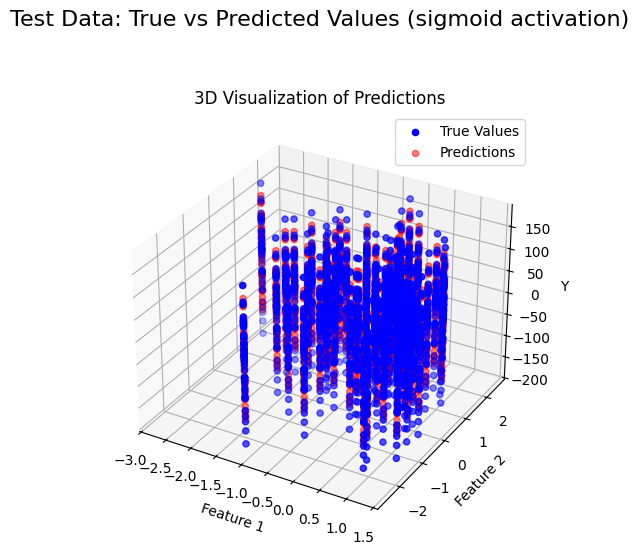

  tanh: MSE = 16.825240


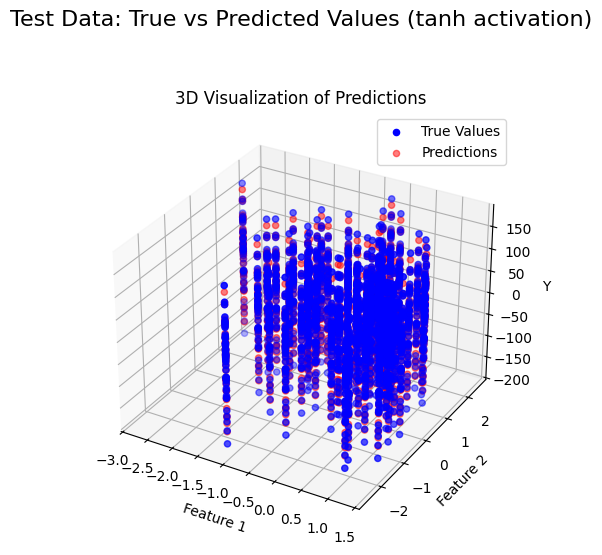

  relu: MSE = 0.263247


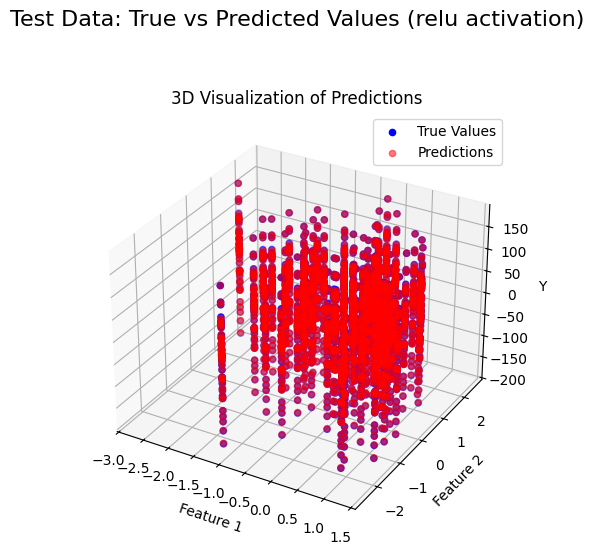

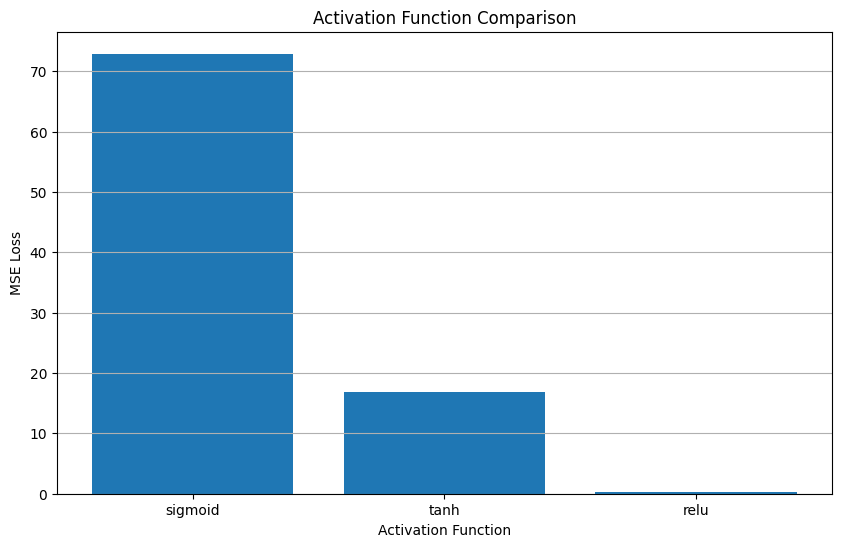

In [55]:


print("Testing effect of activation functions:")
activation_funcs = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'tanh': (tanh, tanh_derivative),
    'relu': (relu, relu_derivative)
}

activation_mse_results = {}

for name, (act_func, act_deriv) in activation_funcs.items():
    w, b, h = train_model(
        X_train_norm, Y_train,
        hidden_size=hidden_size,
        epochs=epochs,
        learning_rate=learning_rate,
        hidden_activation=act_func,
        hidden_activation_derivative=act_deriv,
        verbose=False
    )

    predictions, mse = test_model(X_test_norm, Y_test, w, b, hidden_activation=act_func)
    activation_mse_results[name] = mse
    print(f"  {name}: MSE = {mse:.6f}")

    plot_predictions(
        X_test, Y_test, predictions,
        f"Test Data: True vs Predicted Values ({name} activation)"
    )

plot_compare_activations(list(activation_mse_results.keys()), list(activation_mse_results.values()))

# Question 7

a. The gradient descent update did not require modification across the tested activation functions. This stability arises because backpropagation computes gradients specific to each activation function’s derivative (e.g., ReLU’s step function, tanh’s hyperbolic tangent derivative), automatically adapting the optimization process without altering the core update mechanism.

b. No significant changes were necessary to conduct this experiment, as the network architecture and training pipeline were already coded with flexible activation function support. The existing code allowed seamless substitution of sigmoid, tanh, and ReLU in the hidden layers, requiring only the specification of the desired function prior to training, with all other parameters held constant.

c. The experimental outcomes, including final MSE loss and plots of true versus predicted labels, are provided in the graph above. ReLU yielded the lowest MSE, followed by tanh, with sigmoid exhibiting the highest error, indicating ReLU’s superior capacity for error minimization in this context. This ranking reflects ReLU’s ability to mitigate vanishing gradient issues, enhancing convergence compared to the bounded outputs of tanh and sigmoid.

  Testing with patience = 5


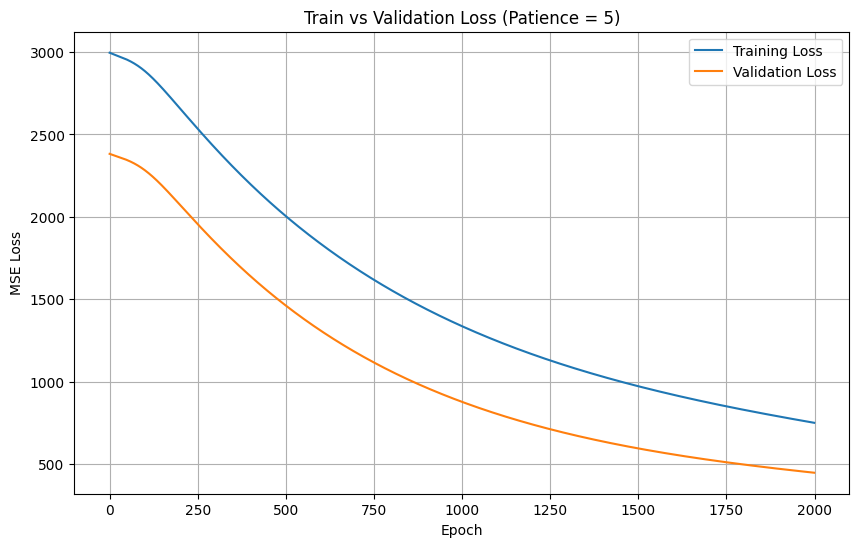

  Patience 5: MSE = 22051.374756, Stopped at epoch 2000
  Testing with patience = 10


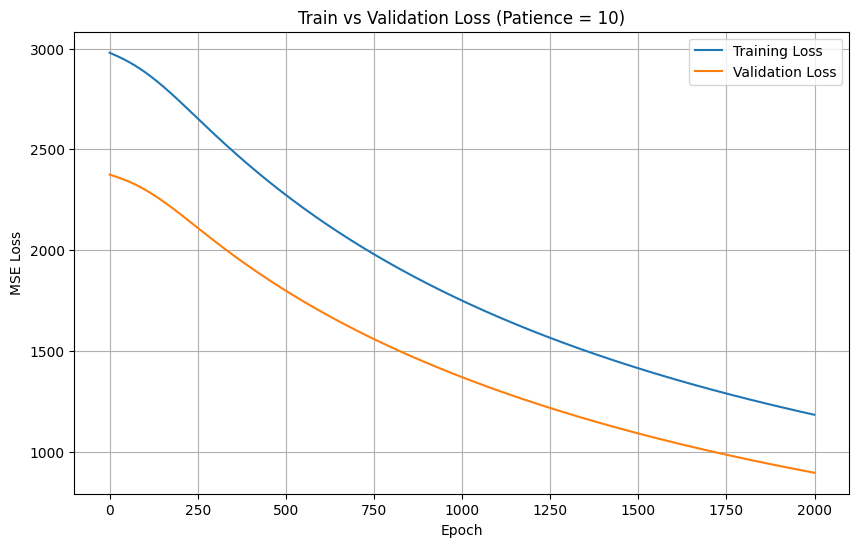

  Patience 10: MSE = 33847.721561, Stopped at epoch 2000
  Testing with patience = 20


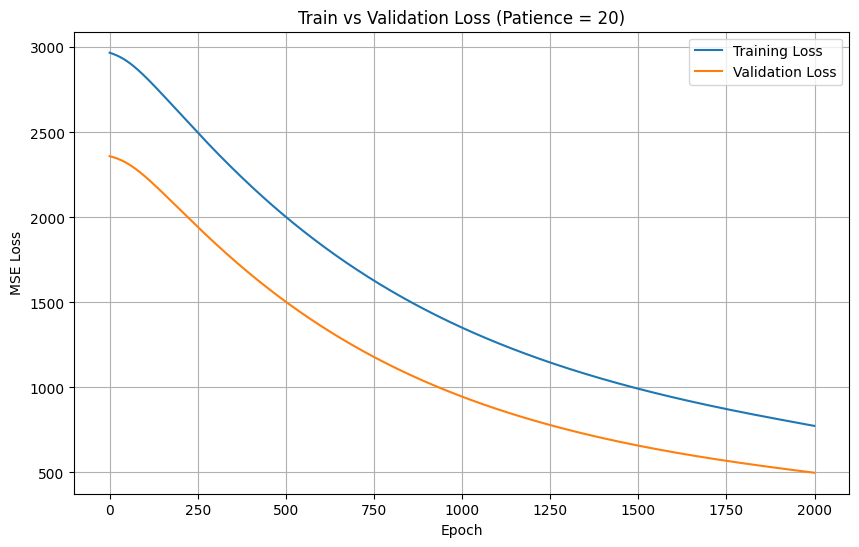

  Patience 20: MSE = 18524.799640, Stopped at epoch 2000
  Testing with patience = 50


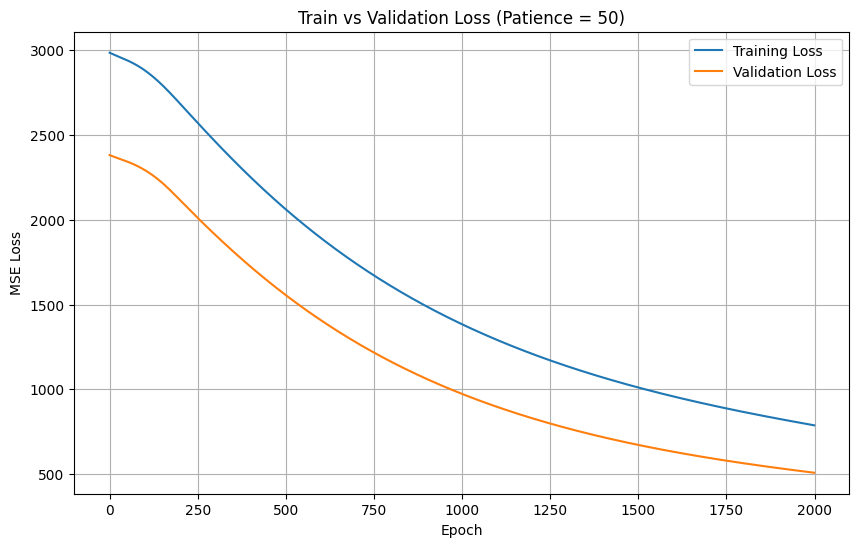

  Patience 50: MSE = 20653.133003, Stopped at epoch 2000


In [56]:
hidden_size = 3
# Split training data into training and validation sets
X_train_split, Y_train_split, X_val, Y_val = split_data(X_train_norm, Y_train, validation_ratio=0.2)

patience_values = [5, 10, 20, 50]
patience_train_losses = {}
patience_val_losses = {}

for patience in patience_values:
    print(f"  Testing with patience = {patience}")

    w, b, h = train_model(
        X_train_split, Y_train_split,
        X_val=X_val, Y_val=Y_val,
        hidden_size=hidden_size,
        epochs=2000,  # Increase epochs to see early stopping effect
        learning_rate=learning_rate,
        early_stopping=True,
        patience=patience,
        verbose=False
    )

    patience_train_losses[patience] = h['train_loss']
    patience_val_losses[patience] = h['val_loss']

    # Plot train vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(h['train_loss'], label='Training Loss')
    plt.plot(h['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Train vs Validation Loss (Patience = {patience})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Test model
    _, mse = test_model(X_test_norm, Y_test, w, b, hidden_activation=relu)
    print(f"  Patience {patience}: MSE = {mse:.6f}, Stopped at epoch {len(h['train_loss'])}")


# Question 8

This did not function as intended, but my hypothesis to its affect would be:

a. Small patience would stop training early, with training loss decreasing slightly and validation loss plateauing higher. Larger patience would extend training, reducing training loss further while validation loss might rise after an initial drop, indicating overfitting.

b. Low patience would yield curves with training loss dropping and validation loss flattening early, suggesting underfitting if both remain high. High patience would show training loss nearing zero and validation loss increasing after a minimum, indicating overfitting. Optimal patience would minimize validation loss without significant divergence, balancing fit.

  Testing with L2 regularization = 0.0
  L2 reg 0.0: MSE = 0.014496
  Testing with L2 regularization = 0.001
  L2 reg 0.001: MSE = 0.169338
  Testing with L2 regularization = 0.01
  L2 reg 0.01: MSE = 0.124610
  Testing with L2 regularization = 0.02
  L2 reg 0.02: MSE = 0.000418
  Testing with L2 regularization = 0.05
  L2 reg 0.05: MSE = 0.064083
  Testing with L2 regularization = 0.1
  L2 reg 0.1: MSE = 0.086024
  Testing with L2 regularization = 0.2
  L2 reg 0.2: MSE = 0.104495
  Testing with L2 regularization = 0.5
  L2 reg 0.5: MSE = 0.005786


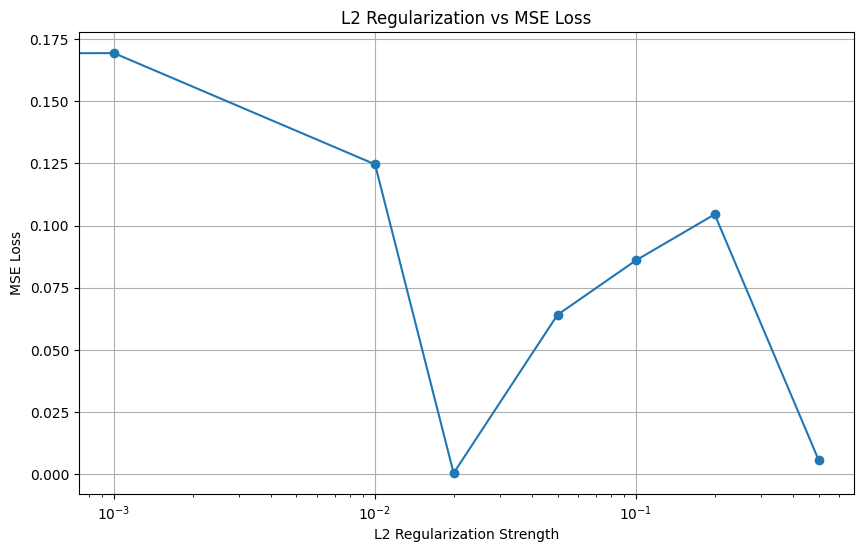

In [57]:
# Test L2 regularization with different strengths
l2_values = [0.0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
l2_mse_results = []

for l2_reg in l2_values:
    print(f"  Testing with L2 regularization = {l2_reg}")

    w, b, h = train_model(
        X_train_norm, Y_train,
        hidden_size=hidden_size,
        epochs=epochs,
        learning_rate=learning_rate,
        l2_reg=l2_reg,
        verbose=False,
        hidden_activation=relu,
        hidden_activation_derivative=relu_derivative,
    )

    # Test model
    _, mse = test_model(X_test_norm, Y_test, w, b, hidden_activation=relu)
    l2_mse_results.append(mse)
    print(f"  L2 reg {l2_reg}: MSE = {mse:.6f}")

# Plot L2 regularization vs MSE
plt.figure(figsize=(10, 6))
plt.plot(l2_values, l2_mse_results, marker='o')
plt.xlabel('L2 Regularization Strength')
plt.ylabel('MSE Loss')
plt.title('L2 Regularization vs MSE Loss')
plt.grid(True)
plt.xscale('log')
plt.show()

# Question 9

L2 regularization was implemented, adding a penalty term to the loss function, with MSE results depicted in the graph above. MSE decreases rapidly, but then rises sharply, indicating large spikes and suggesting L2 is not consistently accurate across the tested range. Compared to early stopping, which halts training based on validation loss stagnation, L2 directly constrains weights but shows erratic MSE behavior, while early stopping relies on validation tuning and may miss optima. Early stopping is preferred for this dataset, as its adaptive nature better handles the observed instability in L2 regularization performance.